In [1]:
# 加载必需的工具库

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.keras import *
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [2]:
# 加载数据集

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

<img src="images/SIGNS.png" style="width:800px;height:400px;">

y = 2


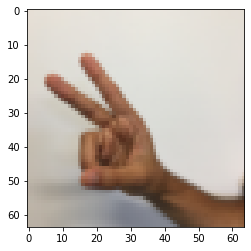

In [3]:
# 我们可以查看部分训练数据的图片

index = 6
plt.imshow(X_train_orig[index])
print('y = ' + str(np.squeeze(Y_train_orig[:, index])))

In [5]:
# 打印出数据的维度，便于排查错误

# 把数据转化为 0-1 之前的数值
X_train = X_train_orig / 255
X_test = X_test_orig / 255

# one hot 编码 (多分类问题)
Y_train = tf.squeeze(tf.one_hot(Y_train_orig, 6))
Y_test = tf.squeeze(tf.one_hot(Y_test_orig, 6))

print ("训练样本数 = " + str(X_train.shape[0]))
print ("测试样本数 = " + str(X_test.shape[0]))
print ("X_train的维度: " + str(X_train.shape))
print ("Y_train的维度: " + str(Y_train.shape))
print ("X_test的维度: " + str(X_test.shape))
print ("Y_test的维度: " + str(Y_test.shape))

conv_layers = {}

训练样本数 = 1080
测试样本数 = 120
X_train的维度: (1080, 64, 64, 3)
Y_train的维度: (1080, 6)
X_test的维度: (120, 64, 64, 3)
Y_test的维度: (120, 6)


使用一些例子介绍 Tensorflow 2.X 专门用于输入数据的接口 tf.data.Dataset

In [6]:
# 手工创建一个非常简单的数据集， 10 个样本，每个样本由 1 个浮点数组成
data = np.array([0.1, 0.4, 0.6, 0.2, 0.8, 0.8, 0.4, 0.9, 0.3, 0.2])

# 大于 0.5 的为正样本，标签为 1，反之为 0
label = np.array([0, 0, 1, 0, 1, 1, 0, 1, 0, 0])

# 使用 tf 建立数据集
dataset = tf.data.Dataset.from_tensor_slices((data, label))

# 可以直接使用 python 语法迭代
for x, y in dataset:
    print('x =', x, 'y =', y)

x = tf.Tensor(0.1, shape=(), dtype=float64) y = tf.Tensor(0, shape=(), dtype=int64)
x = tf.Tensor(0.4, shape=(), dtype=float64) y = tf.Tensor(0, shape=(), dtype=int64)
x = tf.Tensor(0.6, shape=(), dtype=float64) y = tf.Tensor(1, shape=(), dtype=int64)
x = tf.Tensor(0.2, shape=(), dtype=float64) y = tf.Tensor(0, shape=(), dtype=int64)
x = tf.Tensor(0.8, shape=(), dtype=float64) y = tf.Tensor(1, shape=(), dtype=int64)
x = tf.Tensor(0.8, shape=(), dtype=float64) y = tf.Tensor(1, shape=(), dtype=int64)
x = tf.Tensor(0.4, shape=(), dtype=float64) y = tf.Tensor(0, shape=(), dtype=int64)
x = tf.Tensor(0.9, shape=(), dtype=float64) y = tf.Tensor(1, shape=(), dtype=int64)
x = tf.Tensor(0.3, shape=(), dtype=float64) y = tf.Tensor(0, shape=(), dtype=int64)
x = tf.Tensor(0.2, shape=(), dtype=float64) y = tf.Tensor(0, shape=(), dtype=int64)


接下来使用 tf.data.Dataset 处理前面从文件里读出来的数据

In [20]:
# 将 X_train 和 Y_train 打包成 Dataset 对象
ds_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

# 将 X_test 和 Y_test 打包成 Dataset 对象
ds_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)

'''
shuffle -- 洗牌算法
参数列表 (
    buffer_size, seed=None, reshuffle_each_iteration=None, name=None
)
buffer_size -- 大于等于数据长度
seed -- 随机数种子
reshuffle_each_iteration -- 控制每个 epoch 的 shuffle 顺序是否应该不同
'''
# batch(64) 每 64 个样本打包成一组
ds_train = ds_train.shuffle(1080, 1, True).batch(64)

tf.data.Dataset 相关文档：https://www.tensorflow.org/api_docs/python/tf/data/Dataset

接下来使用 **squential** 方式构建 CNN

In [10]:
# 由于 keras 已经被全部导入，下列代码等于 cnnmodel = tf.keras.Sequential()
cnnmodel = Sequential()

# 输入层
cnnmodel.add(layers.Input((64, 64, 3)))

# 添加一个卷积层
# 指定 8 个过滤器，宽高都是 4，深度是 3 (由于过滤器深度必须和输入矩阵相同， 因此无需指定)
# 参数的初始化使用 initializers.GlorotUniform，设置随机种子为 1
# 激活函数设置为 relu，padding 设置为 'same'
cnnmodel.add(layers.Conv2D(filters=8, kernel_size=(4, 4), kernel_initializer=initializers.GlorotUniform(1), 
                            activation='relu', padding='same'))

# 添加一个最大池化层，池化窗口宽高都为 8，步进 8
cnnmodel.add(layers.MaxPool2D(pool_size=(8, 8), strides=(8, 8), padding='same'))

# 添加一个卷积层
cnnmodel.add(layers.Conv2D(filters=16, kernel_size=(2, 2), kernel_initializer=initializers.GlorotUniform(1),
                            activation='relu', padding='same'))

# 添加一个最大池化层
cnnmodel.add(layers.MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same'))

# 添加一个扁平层，将卷积层扁平化
cnnmodel.add(layers.Flatten())

# 添加一个全连接层
# 该层由 6 个神经元，参数由框架生成，激活函数 softmax
cnnmodel.add(layers.Dense(6, kernel_initializer=initializers.GlorotUniform(1), activation='softmax'))

In [11]:
cnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 8)         392       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          528       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 1,310
Trainable params: 1,310
Non-trainable params: 0
____________________________________________________

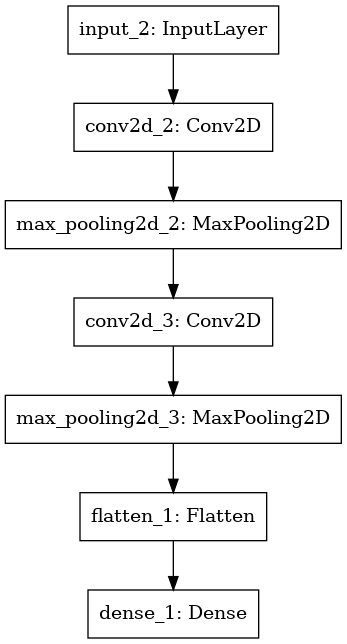

In [12]:
utils.plot_model(cnnmodel, "model.png")

In [13]:
# 编译模型
# 指定优化函数为 adam，指定成本函数为 交叉熵成本函数
cnnmodel.compile(optimizer=optimizers.Adam(),
                 loss=losses.CategoricalCrossentropy(from_logits=True),
                 metrics='acc')

In [14]:
# 训练模型 (训练 100 个 epoch)
history = cnnmodel.fit(ds_train, epochs=100)

Epoch 1/100


2022-06-29 22:36:05.911985: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-29 22:36:05.916607: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2807995000 Hz


17/17 [==============================] - 1s 29ms/step - loss: 1.8311 - acc: 0.1632
Epoch 2/100
17/17 [==============================] - 1s 33ms/step - loss: 1.7901 - acc: 0.2050
Epoch 3/100
17/17 [==============================] - 1s 31ms/step - loss: 1.7842 - acc: 0.2430
Epoch 4/100
17/17 [==============================] - 1s 30ms/step - loss: 1.7806 - acc: 0.2529
Epoch 5/100
17/17 [==============================] - 0s 27ms/step - loss: 1.7739 - acc: 0.2970
Epoch 6/100
17/17 [==============================] - 0s 24ms/step - loss: 1.7653 - acc: 0.3015
Epoch 7/100
17/17 [==============================] - 0s 27ms/step - loss: 1.7522 - acc: 0.3583
Epoch 8/100
17/17 [==============================] - 1s 32ms/step - loss: 1.7395 - acc: 0.3553
Epoch 9/100
17/17 [==============================] - 0s 24ms/step - loss: 1.7154 - acc: 0.4693
Epoch 10/100
17/17 [==============================] - 0s 24ms/step - loss: 1.6911 - acc: 0.4671
Epoch 11/100
17/17 [==============================] - 0s 23ms

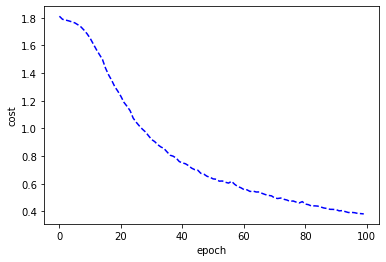

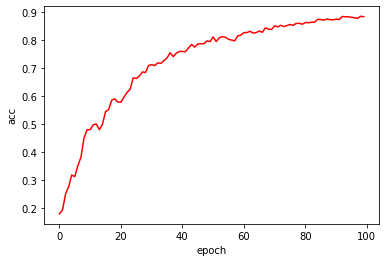

In [17]:
# 打印历史信息
plt.plot(history.history['loss'], 'b--')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['acc'], 'r-')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

In [21]:
# 测试集
loss, acc = cnnmodel.evaluate(ds_test)
print('loss =', loss, 'acc =', acc)

2/2 [==============================] - 0s 15ms/step - loss: 0.5199 - acc: 0.8250
loss = 0.519885241985321 acc = 0.824999988079071


至此，一个可以识别手语的 CNN 程序构建完成，识别率达到了 82%

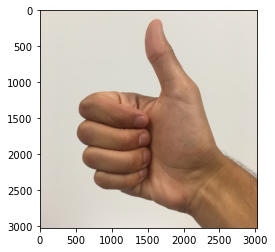

In [22]:
import imageio

fname = "images/thumbs_up.jpg"
image = imageio.imread(fname)

plt.imshow(image)